# Introduction to Kalman Filter

## Utils

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
sns.set_theme(context='talk', )
plt.rcParams["figure.figsize"] = (15,10)
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def mape(y_true, y_pred):
    """
    Calculates mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  # Average method
def avg_forecast(series, h):
    """
    Forecast all future values as the series average
    params:
    - series (array-like): Historical time series
    - h: Forecast horizon
    """
    return np.full((h,), np.mean(series))

# Naive method
def naive_forecast(series, h):
    """
    Forecast all future values as the last observation
    params:
    - series (array-like): Historical time series
    - h: Forecast horizon - number of forecast points
    """
    return np.full((h,), series[-1])

# Drift method
def drift_forecast(series, h):
    """
    Drift forecasting method
    params:
    - series (array-like): the historical data
    - h: Forecast horizon - number of forecast points
    """
    n = series.shape[0]
    yt, y1 = series[-1], series[0]
    output = np.arange(1, h + 1)
    return yt + output * (yt - y1) / (n - 1)

def rmse(y_true, y_pred):
  return np.sqrt(np.mean((y_true-y_pred)**2))

def smape(A, F):
    """
    Calculates symmetric mean absolute percentage error
    parameters:
        A: Actual series
        F: Forecast series
    """
    A, F = np.array(A), np.array(F)
    return (100 / len(A)) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

## What is Kalman Filter
- An estimation algorithm: Produces estimates of hidden variables (hidden state) of the system based on inaccurate measurements.
- First published in 1960 by Rudolf E. Kálmán.
- Applications (to name a few):
    - Target tracking 
    - Navigation system
    - Control system


## The first filters 

### Example 1: Weight estimation

Static system: Does not change the state over a long period of time. Example: weight of a snack bag
- System: The object
- State: Weight of the object.
Assuming the true weight is 10 grams. This is unknown to us and we need to estimate that number.

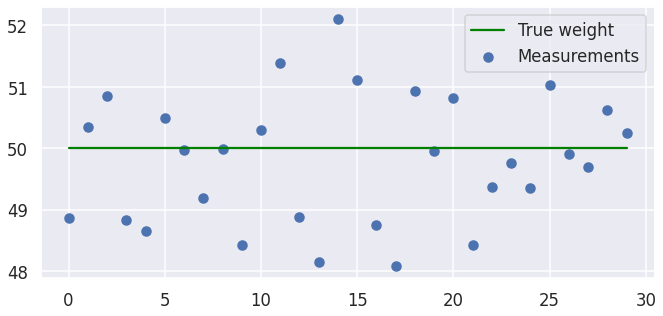

In [11]:
n_measurements = 30
true_value = 50
fig, ax = plt.subplots(figsize=(11, 5))
measurements = np.random.normal(loc=0, scale=1, size=n_measurements,) + true_value
ax.scatter(np.arange(n_measurements), measurements, label='Measurements')
ax.plot(np.arange(n_measurements), [true_value]*n_measurements, label='True weight', color='green')
ax.legend()

In [16]:
# Initial estimate
estimated = 60
estimates = [estimated]
predictions = []
future_predictions = []
deltas = []
scale_factor = 3 / 10 # How we trust the observation
n_test = 10
print(f"Time = 0: estimated weight = {estimated}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated 
    predictions.append(predicted)
    
    # Update step
    # Calculate residuals
    residual = measurements[i] - predicted
    deltas.append(residual)
    # Calculate the current estimate
    estimated = predicted + scale_factor * residual
    
    # Logging
    if i % 10 == 0:
      print(f"Time = {i+1}: estimated weight = {estimated}\t | observation: {measurements[i]}")
    estimates.append(estimated)

# Future prediction
first_prediction = estimates[-1]
for _ in range(n_test):
    # No measurements --> use the previous state estimate as next state prediction
    future_predicted = first_prediction
    future_predictions.append(future_predicted)

Time = 0: estimated weight = 60
Time = 1: estimated weight = 56.65865669870263	 | observation: 48.86218899567544
Time = 11: estimated weight = 49.82854515845439	 | observation: 50.30471028991211
Time = 21: estimated weight = 50.16527566868946	 | observation: 50.815338605157386


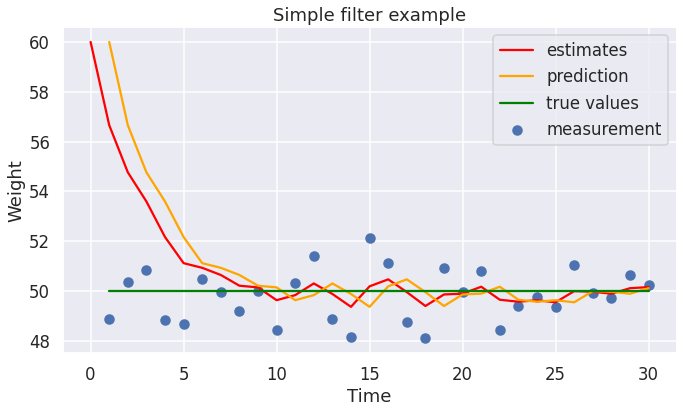

In [17]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), [true_value]*n_measurements, label='true values', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("Simple filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Weight")
ax.legend(loc='best')

- As we can see, as we increase the time step, the estimations tend to converge toward the true weight value.
- Scale factor is how much we trust the observation. The higher the scale factor, the less important our predictions become

### Example 2: Aircraft tracking

The aircraft is a dynamic system (Position changes overtime)

Assuming the aircraft is flying in 1D space. With velocity being the derivative of the distance, 
$$
v = \frac{dx}{dt}
$$
we can calculate the position of the aircraft in the next time frame as follows:
$$
x_{n+1} = x_{n} + \triangle t v
$$
$$
v_{n+1} = v_{n} 
$$

These above functions are called state extrapolation equation, transition or prediction equation.

#### Simple approach, no regard to velocity change

Let's try using the simple filter in the above example to estimate the aircraft position

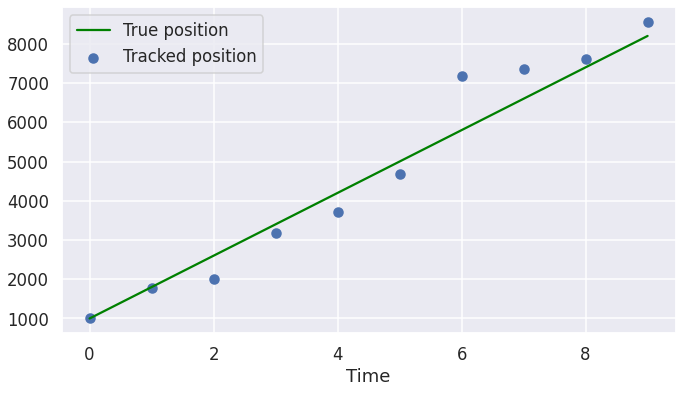

In [18]:
n_measurements = 10
fig, ax = plt.subplots(figsize=(11, 6))
velocities = np.random.normal(loc=0, scale=100, size=n_measurements,) + 800
true_velocities = np.repeat(800, n_measurements)
measurements = 1000 + velocities * np.arange(n_measurements)
true_positions = 1000 + true_velocities * np.arange(n_measurements)
ax.scatter(np.arange(n_measurements), measurements, label='Tracked position')
ax.plot(np.arange(n_measurements), true_positions, label='True position', color='green')
ax.set_xlabel("Time")
ax.legend()

In [19]:
# Initial estimate
estimated = 500
velocity = 850
estimates = [estimated]
predictions = []
deltas = []
time_step = 1
scale_factor = 3/10
# gain = 1/100
n_test = 10
print(f"Time = 0: estimated weight = {estimated}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated + velocity * time_step
    predictions.append(predicted)
    residual = measurements[i] - predicted
    deltas.append(residual)
    # Calculate the current estimate - Update step
    estimated = predicted + scale_factor * residual
    print(f"Time = {i+1}: estimated weight = {estimated}\t | observation: {measurements[i]}")
    estimates.append(estimated)


Time = 0: estimated weight = 500
Time = 1: estimated weight = 1245.0	 | observation: 1000.0
Time = 2: estimated weight = 2001.280197084135	 | observation: 1782.6006569471162
Time = 3: estimated weight = 2596.8294916221103	 | observation: 2003.111178877386
Time = 4: estimated weight = 3367.192511930939	 | observation: 3181.372892651539
Time = 5: estimated weight = 4063.760092742187	 | observation: 3705.7511146351
Time = 6: estimated weight = 4840.463266469887	 | observation: 4669.437338501184
Time = 7: estimated weight = 6135.811273149331	 | observation: 7174.956622068036
Time = 8: estimated weight = 7099.923562736206	 | observation: 7366.1855717722465
Time = 9: estimated weight = 7852.200512387037	 | observation: 7624.18006157231
Time = 10: estimated weight = 8658.418214259907	 | observation: 8556.25951862994


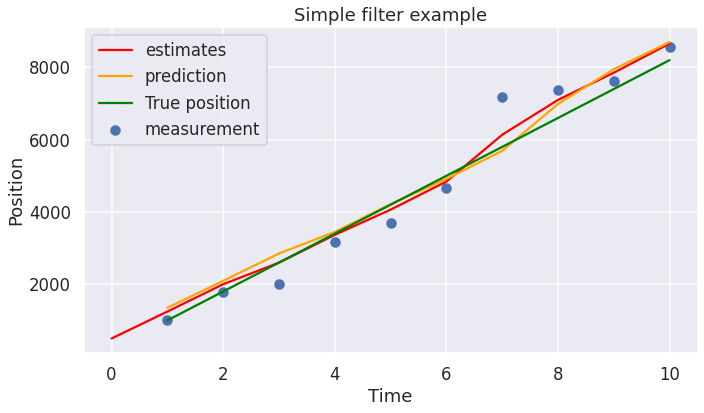

In [20]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), true_positions, label='True position', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("Simple filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.legend(loc='best')

#### Bad initial estimate

What if our initial velocity estimate is way off? 

Time = 0: estimated position = 100 | estimated velocity = 300
Time = 1: estimated position = 580.0	 | estimated velocity = 300 | observation: 1000.0
Time = 2: estimated position = 1150.780197084135	 | estimated velocity = 300 | observation: 1782.6006569471162
Time = 3: estimated position = 1616.4794916221103	 | estimated velocity = 300 | observation: 2003.111178877386
Time = 4: estimated position = 2295.947511930939	 | estimated velocity = 300 | observation: 3181.372892651539
Time = 5: estimated position = 2928.8885927421875	 | estimated velocity = 300 | observation: 3705.7511146351
Time = 6: estimated position = 3661.0532164698866	 | estimated velocity = 300 | observation: 4669.437338501184
Time = 7: estimated position = 4925.2242381493315	 | estimated velocity = 300 | observation: 7174.956622068036
Time = 8: estimated position = 5867.512638236206	 | estimated velocity = 300 | observation: 7366.1855717722465
Time = 9: estimated position = 6604.512865237037	 | estimated velocity = 300 

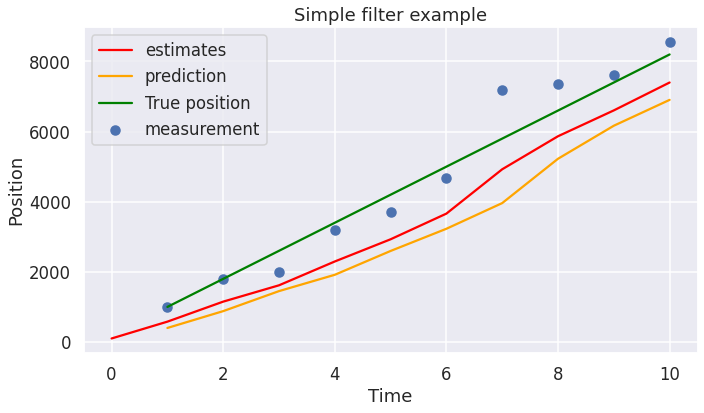

In [21]:
# Initial estimate
estimated = 100
velocity = 300
estimates = [estimated]
predictions = []
deltas = []
time_step = 1
# gain = 1/100
scale_factor = 3/10
n_test = 10
print(f"Time = 0: estimated position = {estimated} | estimated velocity = {velocity}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated + velocity * time_step
    predictions.append(predicted)

    residual = measurements[i] - predicted
    deltas.append(residual)
    
    # Calculate the current estimate - Update step
    estimated = predicted + scale_factor * residual
    print(f"Time = {i+1}: estimated position = {estimated}\t | estimated velocity = {velocity} | observation: {measurements[i]}")
    estimates.append(estimated)

fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), true_positions, label='True position', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("Simple filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.legend(loc='best')


This time our estimates are swaying further from the observations

Assuming at time $n+1$, the position of the aircraft is not exactly what we calculated. What could have happend?
- The radar measurement has noise
- The velocity has changed.

#### Taking velocity change into account

What if the velocity has changed overtime. Can we also update the velocity like we updated the position estimate in each time step? 

State update equation for velocity
$$
v_{n,n} = v_{n, n-1} + \beta (\frac{z_n - x_{n, n-1}}{\triangle t})
$$

Time = 0: estimated position = 100 | estimated velocity = 300
Time = 1: estimated position = 580.0	 | estimated velocity = 480.0 | observation: 1000.0
Time = 2: estimated position = 1276.780197084135	 | estimated velocity = 696.7801970841349 | observation: 1782.6006569471162
Time = 3: estimated position = 1982.4256295810046	 | estimated velocity = 705.6454324968697 | observation: 2003.111178877386
Time = 4: estimated position = 2836.061611249974	 | estimated velocity = 853.6359816689691 | observation: 3181.372892651539
Time = 5: estimated position = 3694.51364943379	 | estimated velocity = 858.4520381838162 | observation: 3705.7511146351
Time = 6: estimated position = 4587.907182882679	 | estimated velocity = 893.3935334488896 | observation: 4669.437338501184
Time = 7: estimated position = 5989.397488052509	 | estimated velocity = 1401.4903051698298 | observation: 7174.956622068036
Time = 8: estimated position = 7383.477126787311	 | estimated velocity = 1394.079638734802 | observation:

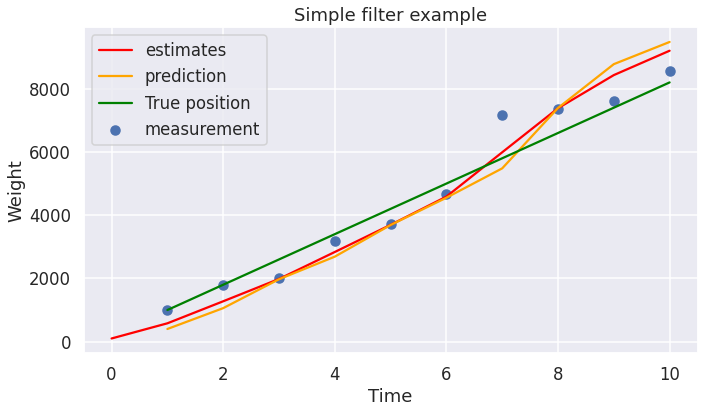

In [22]:
# Initial estimate
estimated = 100
velocity = 300
estimates = [estimated]
predictions = []
deltas = []
time_step = 1
# gain = 1/100
scale_factor = 3/10
scale_factor_2 = 3/10
n_test = 10
print(f"Time = 0: estimated position = {estimated} | estimated velocity = {velocity}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated + velocity * time_step
    predictions.append(predicted)
    residual = measurements[i] - predicted
    deltas.append(residual)
    # Calculate the current estimate - Update step
    estimated = predicted + scale_factor * residual
    velocity = velocity + scale_factor_2 * (residual / time_step)
    print(f"Time = {i+1}: estimated position = {estimated}\t | estimated velocity = {velocity} | observation: {measurements[i]}")
    estimates.append(estimated)

fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), true_positions, label='True position', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("Simple filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Weight")
ax.legend(loc='best')


We just did what is called $\alpha-\beta$ filter. $\alpha$ refers to the scale factor for updating position (system estimate in general), and $\beta$ refers to the scale factor for updating the velocity (rate of change)
- If we trust our measurement device --> high $\alpha$ and $\beta$ would be appropriate
- If the measurement precision is low, lower $\alpha$ and $\beta$ would be better (more smoothing)

## Univariate Kalman filter

Now we can move on to the actual Kalman filter, which also has 2 main steps, similar to $\alpha-\beta$ filter.
- The `predict` step (dynamic model equation)
- The `update` step (state update equation)

### Breaking the steps down

**Predict step**

- If we look at the graph of the previous examples, the difference between the estimates and true values become smaller as we loop through the time steps and it tends to converge to zero. We don't know exactly the estimate error but we can estimate the state/process uncertainty/variance (denoted by $p$).
- Difference between measurement and the true (hidden) values of the system is called measurement error. The variance of measurement errors is called measurement/observation uncertainty/variance (denoted by $r$).

Kalman Filter treats the estimates as random variable, so in addition to extrapolating the estimates, we also need to extrapolate the uncertainty $p$, as shown in this diagram.


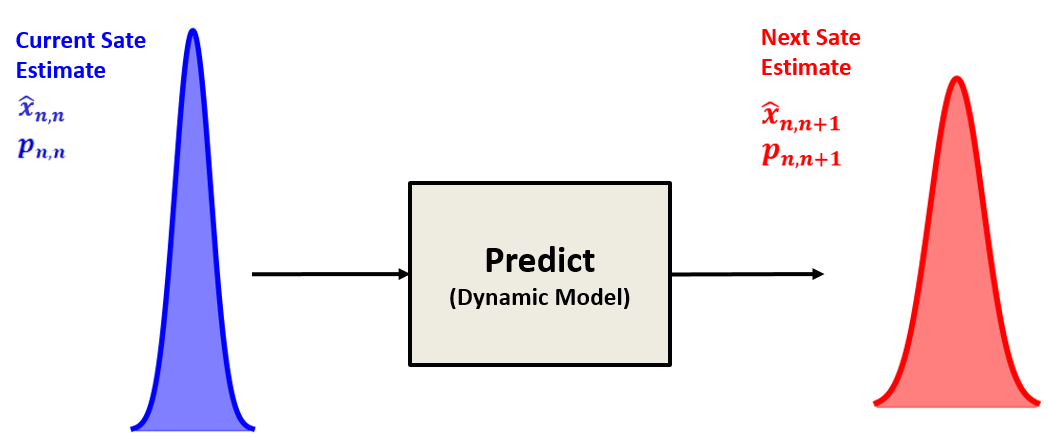

- In example #1, the system is static, so the predicted uncertainty is the same as that of the previous state:
$$
\hat{p}_{n+1,n} = \hat{p}_{n,n} 
$$
- In example #2, the system is dynamic, the predicted uncertainty will be
$$
p^x_{n+1,n} = p^x_{n,n} + p^v_{n,n}
$$
$$
p^v_{n+1,n} = p^v_{n,n}
$$
(assuming constant velocity)

**Update step**

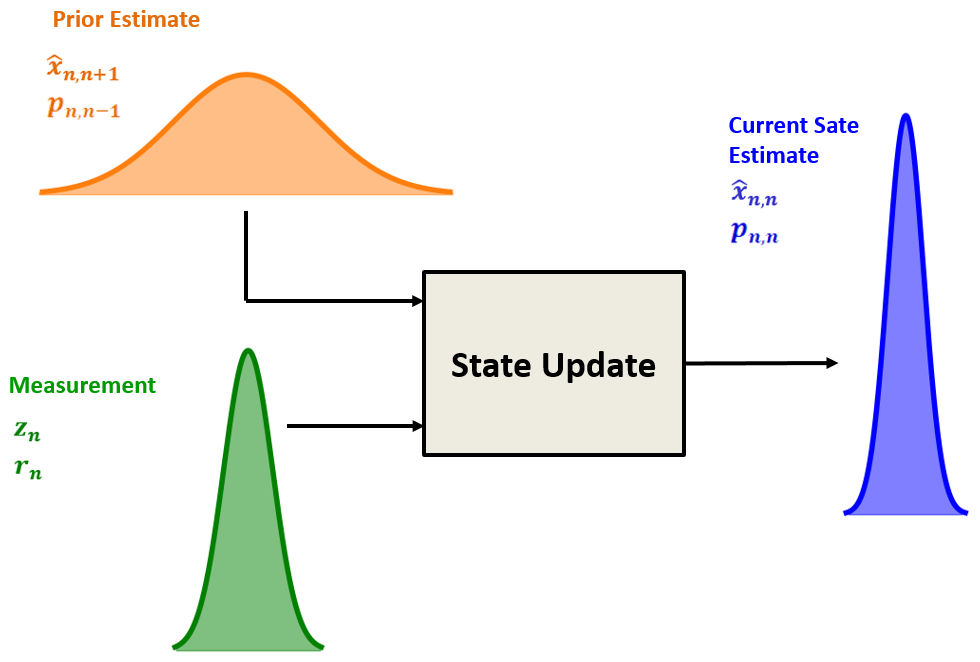

Similar to the $α-β$ filter, in order to estimate the current state, we combine the prediction (prior state estimate) and the current measurement (observation) at time *n*. But this time these two are random, normal variables. 

As Kalman Filter is optimal, we need to minimise the uncertainty. Considering the update function for the current state estimate, which is the weighted mean of measurement and prediction:
$$
\hat{x}_{n,n} = w_1z_n + (1 - w_1)\hat{x}_{n,n-1}
$$

and for the uncertainty (variance):
$$
p_{n,n} = w_1^2r_n + (1 - w_1)^2p_{n,n-1}
$$
Where
- $p_{n,n}$ is the variance of the estimate
- $p_{n,n-1}$ is the variance of the prediction (prior estimate)
- $r_n$ is the measurement variance

To minimise the uncertainty, which is the variance $p_{n,n}$, we take the derivative with respect to the weight $w_1$ ($\frac{dp_{n,n}}{dw_1}$) and set it to zero. Therefore we have
$$
2w_1r_n - 2(1 - w_1)p_{n, n - 1} = 0
$$
Hence
$$
w_1 = \frac{p_{n,n-1}}{p_{n,n-1} + r_n}
$$
This weight is called **Kalman Gain** ($K_n$). With this we can rewrite the update equation as follows:
$$
\hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n (z_n - \hat{x}_{n,n-1})
$$
This is similar to the equation from $α-β$ filter. 

And by substitution, we can rewrite the update equation for the variance of estimate as:
$$
p_{n,n} = (1 - K_n)p_{n,n-1}
$$

#### Kalman Gain interpretation
- Similar to $α-β$ filter, $K_n$ is close to zero if we trust the estimate more than the measurement (measurement uncertainty is high). When measurement uncertainty is low and estimate uncertainty is high, $K_n$ is close to $1$.
- The Kalman Gain defines the weight of the measurement and the weight of the previous estimate when forming a new estimate. It tells us how much the measurement changes the estimate.

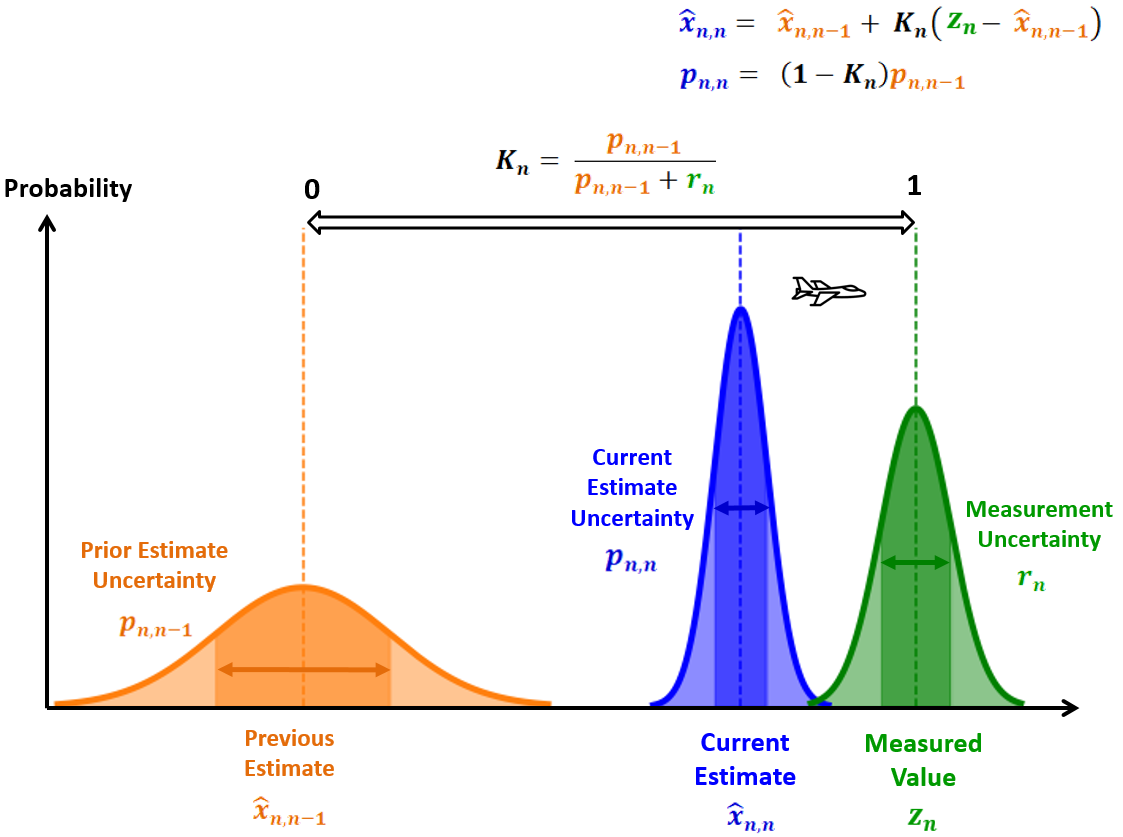

### Example 3: Weight estimation - revisited
This time we will estimate the weight using Kalman Filter. 

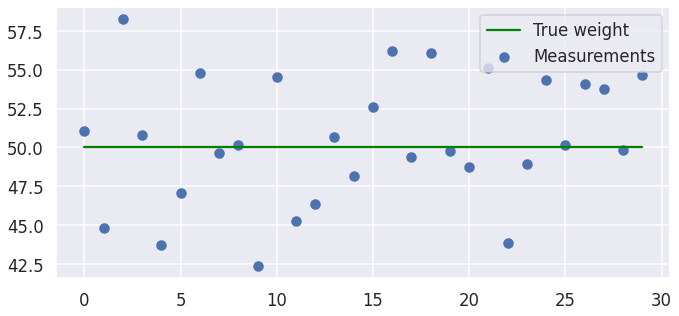

In [23]:
n_measurements = 30
true_value = 50
fig, ax = plt.subplots(figsize=(11, 5))
measurements = np.random.normal(loc=0, scale=5, size=n_measurements,) + true_value
ax.scatter(np.arange(n_measurements), measurements, label='Measurements')
ax.plot(np.arange(n_measurements), [true_value]*n_measurements, label='True weight', color='green')
ax.legend()

In [24]:
# Initial estimate
estimated = 40
# Init estimation uncertainty
estimation_var = 100 # human guess std is 10
estimation_vars = [estimation_var]
# Init measurement uncertainty
sensor_var = 25
estimates = [estimated]
predictions = []
Ks = []
# scale_factor = 3 / n_measurements # How we trust the observation
# n_test = 10
print(f"Time = 0: estimated weight = {estimated}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated 
    predictions.append(predicted)
    # Update step
    # Calculate Kalman gain
    K = estimation_var / (estimation_var + sensor_var)
    # Calculate residuals
    residual = measurements[i] - predicted
    # Calculate the current estimate 
    estimated = predicted + K * residual
    # Calculate the current estimation uncertainty
    estimation_var = (1 - K) * estimation_var 
    if i % 5 == 0:
      print(f"Time = {i+1}: estimated weight = {estimated}\t | K = {K}\t | observation: {measurements[i]}")
    estimates.append(estimated)
    estimation_vars.append(estimation_var)
    Ks.append(K)

Time = 0: estimated weight = 40
Time = 1: estimated weight = 48.84767096037679	 | K = 0.8	 | observation: 51.05958870047099
Time = 6: estimated weight = 48.90846962294251	 | K = 0.16	 | observation: 47.08617199332841
Time = 11: estimated weight = 49.523003299267614	 | K = 0.08888888888888889	 | observation: 54.500609314800045
Time = 16: estimated weight = 49.242966812215435	 | K = 0.06153846153846155	 | observation: 52.607807492433786
Time = 21: estimated weight = 49.89938311916803	 | K = 0.047058823529411764	 | observation: 48.73798181101586
Time = 26: estimated weight = 50.0065337756346	 | K = 0.0380952380952381	 | observation: 50.15956443285998


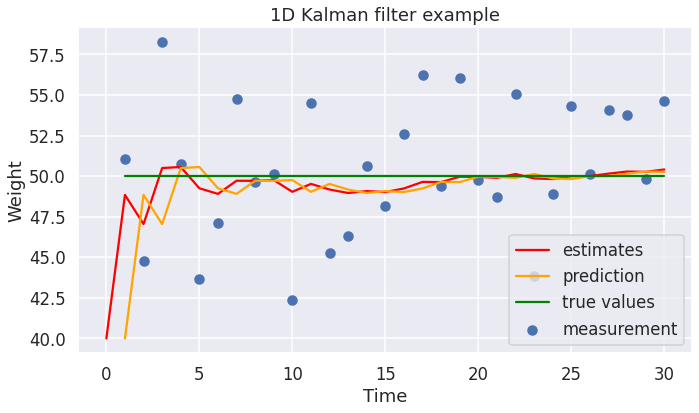

In [25]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), [true_value]*n_measurements, label='true values', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("1D Kalman filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Weight")
ax.legend(loc='best')

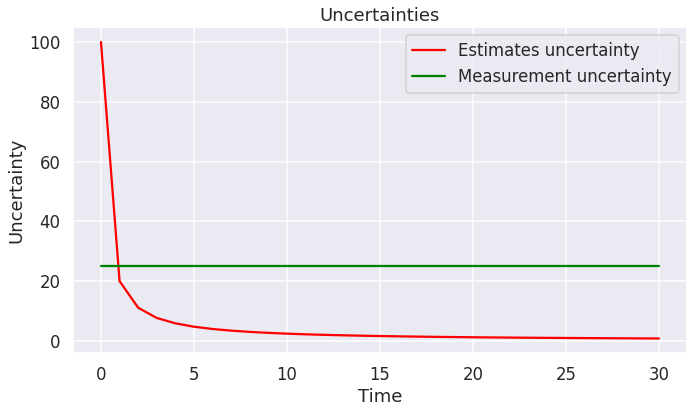

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(np.arange(0, n_measurements+1), estimation_vars, label='Estimates uncertainty', color='red')
ax.plot(np.arange(0, n_measurements+1), [sensor_var]*(n_measurements+1), label='Measurement uncertainty', color='green')
ax.set_title("Uncertainties")
ax.set_xlabel("Time")
ax.set_ylabel("Uncertainty")
ax.legend(loc='best')

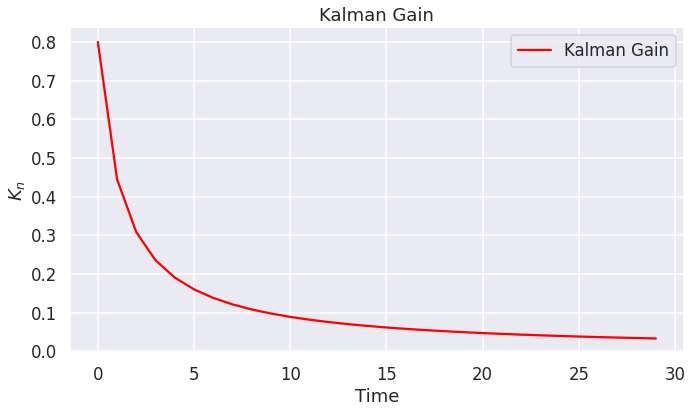

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(np.arange(0, n_measurements), Ks, label='Kalman Gain', color='red')
ax.set_title("Kalman Gain")
ax.set_xlabel("Time")
ax.set_ylabel("$K_n$")
ax.legend(loc='best')

We can see that the estimate uncertainty gets lower with each iteration, so does the Kalman gain

### Adding process noise

- In the previous example, the system is static, therefore in our prediction step, the predicted value is the same as the last time step estimate.
- In the aircraft tracking example, the real position of the aircraft is not exactly what we expected from the motion equation, which might be caused by random changes in the velocity. We call that process noise (or system noise/model noise)
- Process noise is denoted by $q$


### Example 4: Aircraft tracking - revisited

This time we assume the velocity is not constant and has some process noise (variance), hence the true positions of the aircraft is not a perfect line.

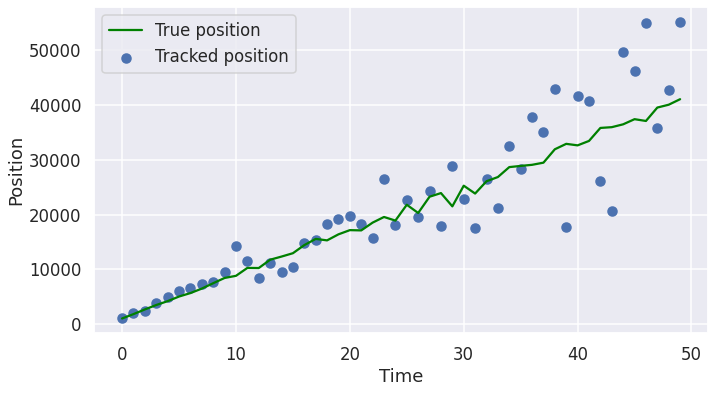

In [26]:
n_measurements = 50
fig, ax = plt.subplots(figsize=(11, 6))
velocities = np.random.normal(loc=0, scale=200, size=n_measurements,) + 800
true_velocities_with_noise = 800 + np.random.normal(loc=0, scale=30, size=n_measurements)
measurements = 1000 + velocities * np.arange(n_measurements)
true_positions = 1000 + true_velocities_with_noise * np.arange(n_measurements)
ax.scatter(np.arange(n_measurements), measurements, label='Tracked position')
ax.plot(np.arange(n_measurements), true_positions, label='True position', color='green')
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.legend()

In [33]:
# Initial estimate
estimated = 800
# Init estimation uncertainty
estimation_var = 10000 
estimation_vars = [estimation_var]
# Init measurement uncertainty (radar precision)
sensor_var = 2500
# velocity
v = 300
# Init process noise
process_noise = 100
estimates = [estimated]
predictions = []
Ks = []
# scale_factor = 3 / n_measurements # How we trust the observation
# n_test = 10
print(f"Time = 0: estimated position = {estimated}")
for i in range(measurements.shape[0]):
    # Predict step:
    predicted = estimated + v
    estimation_var = estimation_var + process_noise
    predictions.append(predicted)
    # Update step
    # Calculate Kalman gain
    K = estimation_var / (estimation_var + sensor_var)
    # Calculate residuals
    residual = measurements[i] - predicted
    # Calculate the current estimate 
    estimated = predicted + K * residual
    # Calculate the current estimation uncertainty
    estimation_var = (1 - K) * estimation_var 
    if i % 5 == 0:
      print(f"Time = {i+1}: estimated position = {estimated}\t | K = {K}\t | observation: {measurements[i]}")
    estimates.append(estimated)
    estimation_vars.append(estimation_var)
    Ks.append(K)

Time = 0: estimated position = 800
Time = 1: estimated position = 1019.8412698412699	 | K = 0.8015873015873016	 | observation: 1000.0
Time = 6: estimated position = 4283.628567136563	 | K = 0.21709919872671382	 | observation: 6073.660342115229
Time = 11: estimated position = 8720.06167012972	 | K = 0.18554652671758223	 | observation: 14337.520882652188
Time = 16: estimated position = 10505.691221031406	 | K = 0.18160921870922767	 | observation: 10409.871491194473
Time = 21: estimated position = 16078.154677031385	 | K = 0.18108046395351074	 | observation: 19645.250351797888
Time = 26: estimated position = 19839.71042279611	 | K = 0.18100877399846937	 | observation: 22711.332341561767
Time = 31: estimated position = 22785.080545032248	 | K = 0.180999041539952	 | observation: 22915.081064631155
Time = 36: estimated position = 25866.976467684464	 | K = 0.18099772005315662	 | observation: 28390.068053338393
Time = 41: estimated position = 32358.500944168136	 | K = 0.18099754061557186	 | ob

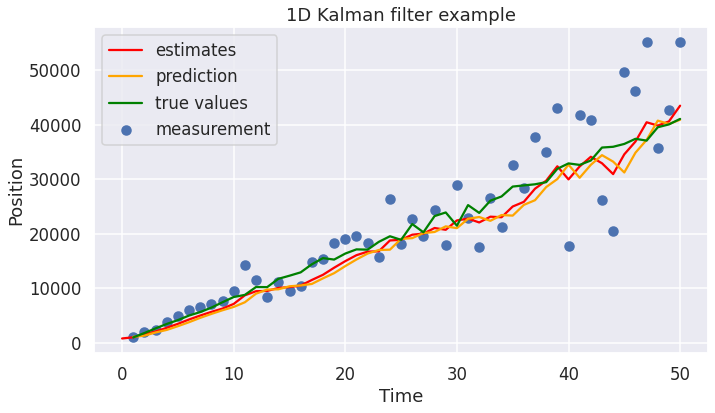

In [34]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(np.arange(1, n_measurements+1), measurements, label='measurement')
ax.plot(np.arange(0, n_measurements+1), estimates, label='estimates', color='red')
ax.plot(np.arange(1, n_measurements+1), predictions, label='prediction', color='orange')
ax.plot(np.arange(1, n_measurements+1), true_positions, label='true values', color='green')
# ax.plot(np.arange(n_measurements, n_measurements + n_test), future_predictions, label='predictions', color='orange')
ax.set_title("1D Kalman filter example")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.legend(loc='best')

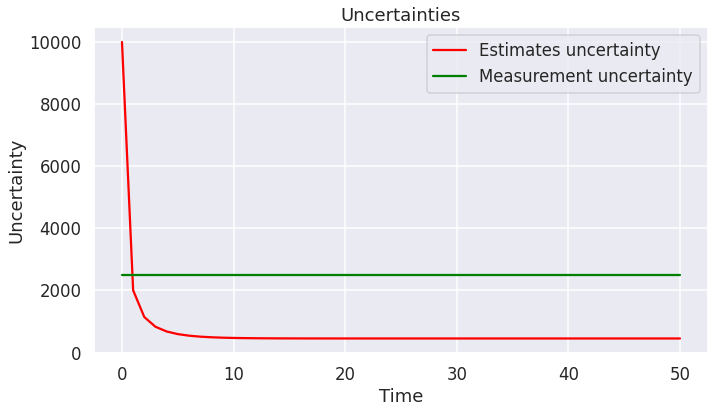

In [35]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(np.arange(0, n_measurements+1), estimation_vars, label='Estimates uncertainty', color='red')
ax.plot(np.arange(0, n_measurements+1), [sensor_var]*(n_measurements+1), label='Measurement uncertainty', color='green')
ax.set_title("Uncertainties")
ax.set_xlabel("Time")
ax.set_ylabel("Uncertainty")
ax.legend(loc='best')

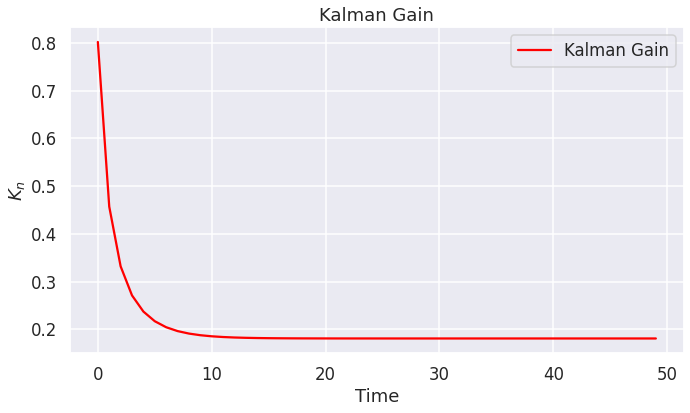

In [36]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(np.arange(0, n_measurements), Ks, label='Kalman Gain', color='red')
ax.set_title("Kalman Gain")
ax.set_xlabel("Time")
ax.set_ylabel("$K_n$")
ax.legend(loc='best')

- If the process (i.e. the motion equation) is not well-defined, we have to use high process noise, which results in high Kalman gain.
- On the other hand, low process noise can result in low $K_n$ (smoother estimate, but might be swaying away from the true values)

## Multivariate Kalman Filter

### Equations breakdown

#### State Prediction (State extrapolation)
$$
\hat{x}_{n+1,n} = F\hat{x}_{n,n} + Gu_n + w_n
$$
Where:
- $\hat{x}_{n,n}$: Estimated state vector at time step $n$
- $\hat{x}_{n+1,n}$: Predicted state vector at time step $n+1$
- $u_n$: Control variable/input variable
- $w_n$: Process noise
- $F$: State transition matrix
- $G$: Control matrix/Input transition matrix


**Example: Falling object**
Consider a system of a falling object. There should be the altitude $h$ and the velocity $\dot{h}$. Therefore the state vector of this system is:
$$
\hat{x}_{n} =
  \left[ {\begin{array}{cc}
    \hat{h}_{n} \\
    \hat{\dot{h}}_{n} \\
  \end{array} } \right]
$$
We can consider the falling acceleration external input to the system, while the position and velocity of the object are the main state. Hence we can have the state transition matrix $F$ as:

$$
F = 
\left[ {\begin{array}{cc}
    1 & \Delta t \\
    0 & 1 \\
  \end{array} } \right]
$$

And the control matrix $G$:

$$
G = 
\left[ {\begin{array}{cc}
    0.5\Delta t^2 \\
    \Delta t \\
  \end{array} } \right]
$$

And the input variable $u_n$

$$
u_n = \left[ {\begin{array}{cc}
    g \\
  \end{array} } \right]
$$

These are equivalent to this system of equation:
$$
\begin{equation}
    \begin{cases}
      \hat{h}_{n+1,n} = \hat{h}_{n,n} + \hat{\dot{h}}_{n,n}Δt + 0.5Δt^2g   \\
      \hat{\dot{h}}_{n+1,n} = \hat{\dot{h}}_{n,n} + Δtg
    \end{cases}\,.
\end{equation}
$$

#### Covariance extrapolation

$$
P_{n+1,n} = FP_{n,n}F^T + Q
$$
Where
- $P_{n,n}$: Covariance matrix of estimate 
- $P_{n+1,n}$: Covariance matrix of prediction for next state
- $F$: State transition
- $Q$: Process noise matrix

As discussed in last section: 
- Too small process noise --> risk of lag error 
- Too high process noise --> noisy estimations which follow closely the measurements

#### Measurement equation

$$
z_n = Hx_n + + v_n
$$

Where:
- $z_n$: Measurement vector
- $x_n$: True state of the system (hidden state)
- $H$: observation matrix
- $v_n$: Random noise vector 

Why need an observation matrix? In some cases, the measured value is not of the same output type as the system state. There is a need for a transformation of the system state (input) to the measurement (output). The observation matrix $H$ is used to convert the system state into outputs using linear transformations.

Example: Time series as a system
- Measurement of each timestep is a scalar $z_n$
- However the system can have multiple components (seasonal, trend, etc.) --> need a matrix $H$ to transform it to a single scalar

#### State update equation

$$
\hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n (z_n - H\hat{x}_{n,n-1})
$$
Where:
- $\hat{x}_{n,n}$: Estimated state vector at time step $n$
- $\hat{x}_{n,n-1}$: Predicted system state at step $n - 1$
- $K_n$: Kalman Gain
- $z_n$: Measurement vector
- $H$: Observation matrix

#### Kalman Gain Update Equation

$$
K_n = P_{n,n-1}H^T(HP_{n,n-1}H^T + R_n)^{-1}
$$
Where:
- $P_{n,n-1}$: Covariance matrix of predicted state
- $H$: Observation matrix
- $R_n$: Measurement noise/covariance

#### Covariance Update Equation

$$
P_{n,n} = (I - K_nH)P_{n,n-1}
$$
Where:
- $P_{n,n}$: Covariance matrix of current state estimation
- $P_{n,n-1}$: Covariance matrix of predicted state
- $K_n$: Kalman Gain
- $H$: Observation matrix
- $I$: Identity matrix

### Example 5: Time series smoothing & forecasting

Data is taken from: https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data

In [7]:
df = pd.read_csv("/content/drive/MyDrive/data/kaggle-web-traffic/train_1.csv.zip", index_col='Page')

In [8]:
df.shape

(145063, 550)

In [37]:
df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Page,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [38]:
df1 = df.iloc[0,:].to_frame(name='traffic')
# measurements = np.log1p(df1.traffic.to_numpy())
measurements = df1.traffic.to_numpy()
df1

,traffic
2015-07-01,18.0
2015-07-02,11.0
2015-07-03,5.0
2015-07-04,13.0
2015-07-05,14.0
...,...
2016-12-27,20.0
2016-12-28,22.0
2016-12-29,19.0
2016-12-30,18.0


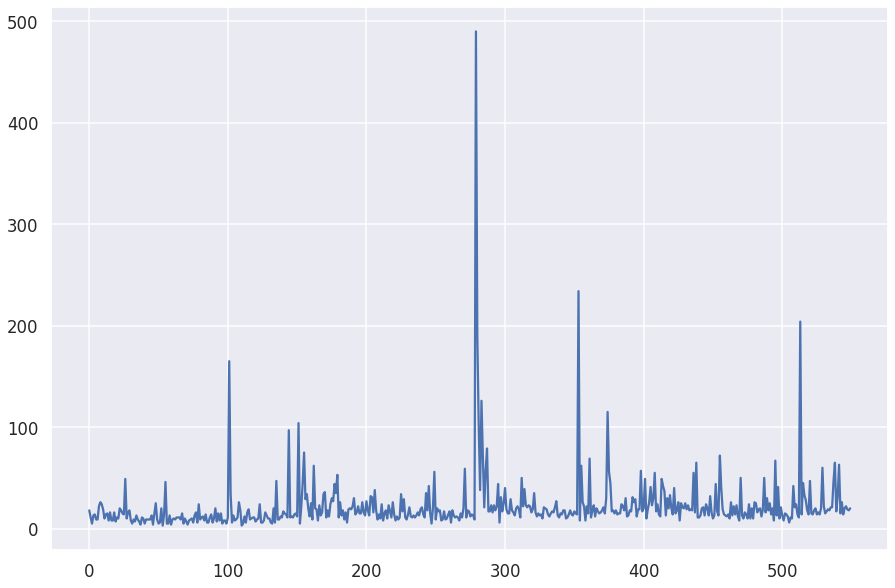

In [39]:
plt.plot(np.arange(len(df1)), measurements)

In [41]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

In [42]:
len(measurements)

550

In [43]:
n_test = 30 

In [53]:
print("AVG forecast: MAPE =", mape(avg_forecast(measurements[:-n_test], n_test), measurements[-n_test:]))
print("Naive forecast: MAPE =", mape(naive_forecast(measurements[:-n_test], n_test), measurements[-n_test:]))
print("Drift forecast: MAPE =", mape(drift_forecast(measurements[:-n_test], n_test), measurements[-n_test:]))

AVG forecast: MAPE = 42.936019731954474
Naive forecast: MAPE = 78.33333333333331
Drift forecast: MAPE = 79.89954946259074


In [55]:
# Init parameters
dt = 1
smoothing_factor = 1
observation_noise = 0.2
level_noise = 0.2 / smoothing_factor

# Transition matrix
F = np.array([
    [1, dt],
    [0,  0.5]
])
# Observation model
H = np.array([
  [1, 1]  
])
# Process noise
Q = np.array([
    [level_noise**2, 0],
    [0, 0]
])
# Observation noise
R = np.array([observation_noise**2]).reshape(1, 1)
print("F: ", F.shape)
print("H: ", H.shape)
print("Q: ", Q.shape)
print("R: ", R.shape)

print("Running Kalman filter")
kf = KalmanFilter(F=F, H=H, Q=Q, R=R)
predictions = []
for z in measurements[:-n_test]:
  predictions.append(np.dot(H, kf.predict())[0])
  kf.update(z)

for _ in range(n_test):
  predictions.append(np.dot(H, kf.predict())[0])
print("Kalman filter with simple transition matrix: MAPE =", mape(measurements[-n_test:], predictions[-n_test:]))

F:  (2, 2)
H:  (1, 2)
Q:  (2, 2)
R:  (1, 1)
Running Kalman filter
Kalman filter with simple transition matrix: MAPE = 24.37543893171346


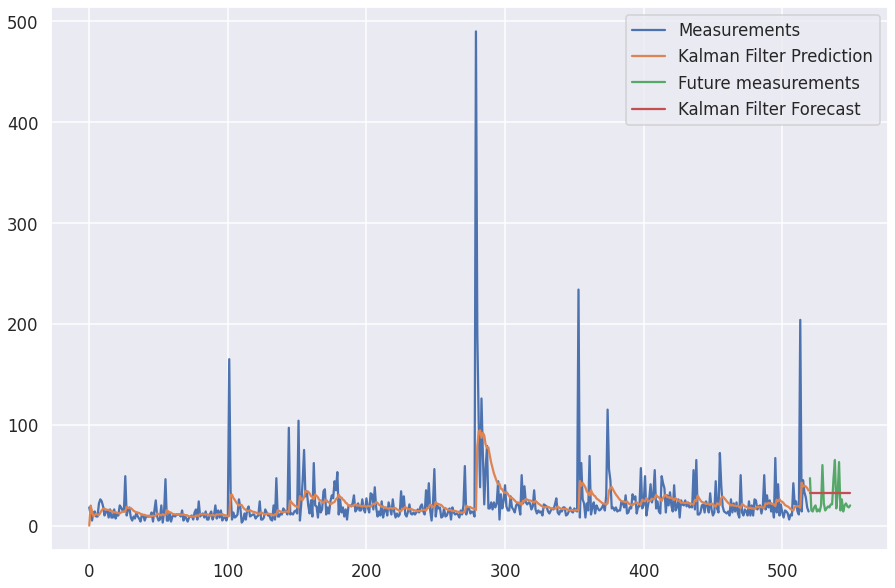

In [49]:
plt.plot(range(len(measurements) - n_test), measurements[:-n_test], label = 'Measurements')
plt.plot(range(len(predictions) - n_test), np.array(predictions[:-n_test]), label = 'Kalman Filter Prediction')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), measurements[-n_test:], label = 'Future measurements')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), np.array(predictions[-n_test:]), label = 'Kalman Filter Forecast')
# plt.plot(np.arange(len(measurements) - n_test, len(measurements)), avg_forecast(measurements[:-n_test], n_test), label='Mean forecast')
plt.legend()
plt.show()

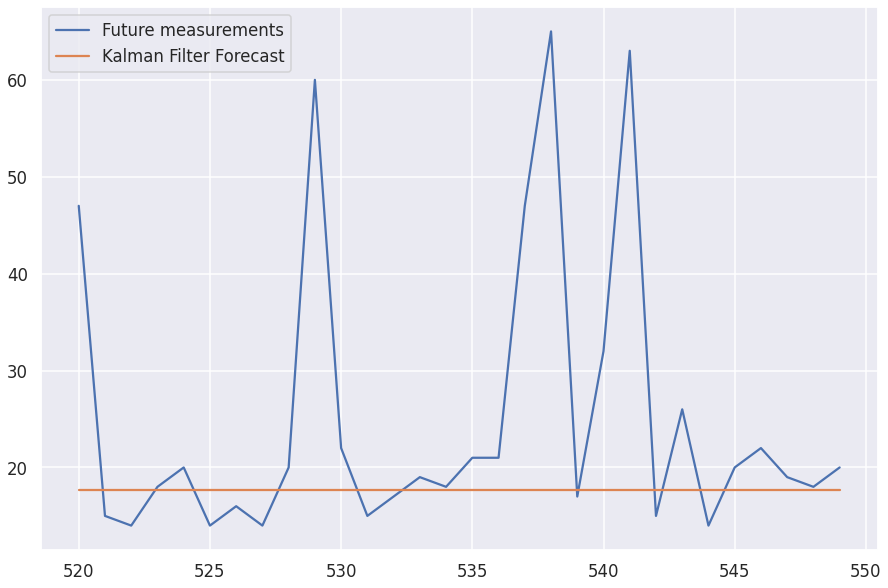

In [ ]:
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), measurements[-n_test:], label = 'Future measurements')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), np.array(predictions[-n_test:]), label = 'Kalman Filter Forecast')
# plt.plot(np.arange(len(measurements) - n_test, len(measurements)), avg_forecast(measurements[:-n_test], n_test), label='Mean forecast')
plt.legend()
plt.show()

In [56]:
smoothing_factor = 1
n_seasons = 7
F = np.zeros((n_seasons+1, n_seasons+1))
# hidden level
F[0, 0] = 1
# season cycle
F[1, 1:-1] = [-1.0] * (n_seasons-1)
F[2:, 1:-1] = np.eye(n_seasons-1)
H = np.array([[1,1] + [0]*(n_seasons-1)])

# --- noise models, parametrized by the smoothing factor
level_noise = 0.2 / smoothing_factor
observation_noise = 0.2
season_noise = 1e-3

Q = np.diag([level_noise, season_noise] + [0]*(n_seasons-1))**2
R = np.array([observation_noise**2]).reshape(1, 1)
print("F: ", F.shape)
print("H: ", H.shape)
print("Q: ", Q.shape)
print("R: ", R.shape)

print("Running Kalman filter")
kf = KalmanFilter(F=F, H=H, Q=Q, R=R)
predictions = []
for z in measurements[:-n_test]:
  predictions.append(np.dot(H, kf.predict())[0])
  kf.update(z)

for _ in range(n_test):
  predictions.append(np.dot(H, kf.predict())[0])

print("Kalman filter with seasonal transition matrix: MAPE =", mape(measurements[-n_test:], predictions[-n_test:]))

F:  (8, 8)
H:  (1, 8)
Q:  (8, 8)
R:  (1, 1)
Running Kalman filter
Kalman filter with seasonal transition matrix: MAPE = 26.54380097723479


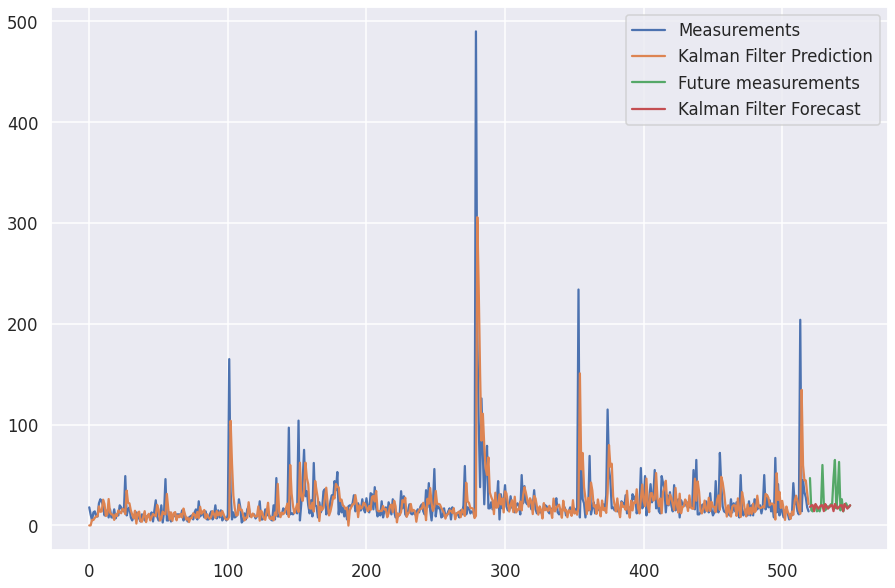

In [51]:
plt.plot(range(len(measurements) - n_test), measurements[:-n_test], label = 'Measurements')
plt.plot(range(len(predictions) - n_test), np.array(predictions[:-n_test]), label = 'Kalman Filter Prediction')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), measurements[-n_test:], label = 'Future measurements')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), np.array(predictions[-n_test:]), label = 'Kalman Filter Forecast')
# plt.plot(np.arange(len(measurements) - n_test, len(measurements)), avg_forecast(measurements[:-n_test], n_test), label='Mean forecast')
plt.legend()
plt.show()

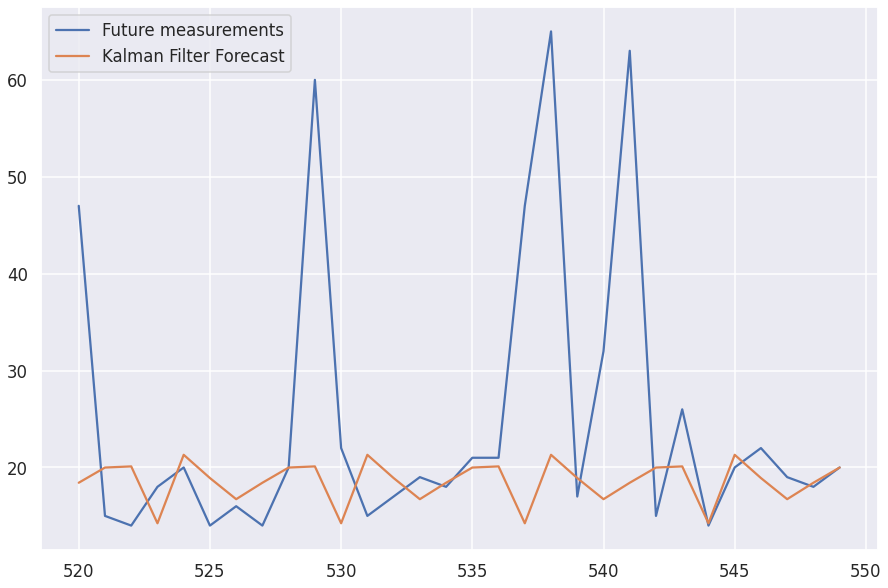

In [52]:
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), measurements[-n_test:], label = 'Future measurements')
plt.plot(np.arange(len(measurements) - n_test, len(measurements)), np.array(predictions[-n_test:]), label = 'Kalman Filter Forecast')
# plt.plot(np.arange(len(measurements) - n_test, len(measurements)), avg_forecast(measurements[:-n_test], n_test), label='Mean forecast')
plt.legend()
plt.show()

## References

- [https://en.wikipedia.org/wiki/Kalman_filter](https://en.wikipedia.org/wiki/Kalman_filter)
- [https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43727](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43727)
- [https://www.kalmanfilter.net/default.aspx](https://www.kalmanfilter.net/default.aspx)